In [1]:
import pandas as pd
import s3fs
import gc


# --- IMPORTANT: REPLACE WITH YOUR BUCKET NAME ---
bucket_name = "recproject-recdata"
# ----------------------------------------------

# The path to the folder where our processed data was saved by AWS Glue
# It should end with a trailing slash "/"
processed_data_path = f"s3://{bucket_name}/processed-data/"

print(f"Reading processed data from: {processed_data_path}")

# Use pandas to read all the Parquet files in the specified folder
df = pd.read_parquet(processed_data_path)

gc.collect()

# Print the shape of the DataFrame (rows, columns)
print(f"Shape of the DataFrame: {df.shape}")

# Display the first 5 rows of the DataFrame
print("\nFirst 5 rows of the data:")
df.head()

Reading processed data from: s3://recproject-recdata/processed-data/
Shape of the DataFrame: (3017439, 3)

First 5 rows of the data:


,rating,title,text
0,5.0,Five Stars,"Great headphones, comfortable and sound is goo..."
1,3.0,nice sound. pedal failed after less than 1 year,I like the piano.. but the sustain pedal faile...
2,4.0,okay,pretty good overall. I like it. the controll...
3,3.0,Easy to return.,Too bad it didn't work. At least the return pr...
4,5.0,Good product despite tight bolt.,Good and sturdy but the bolt was hell to get o...


Distribution of star ratings:
rating
5.0    2024128
4.0     400387
1.0     264352
3.0     197131
2.0     131441
Name: count, dtype: int64


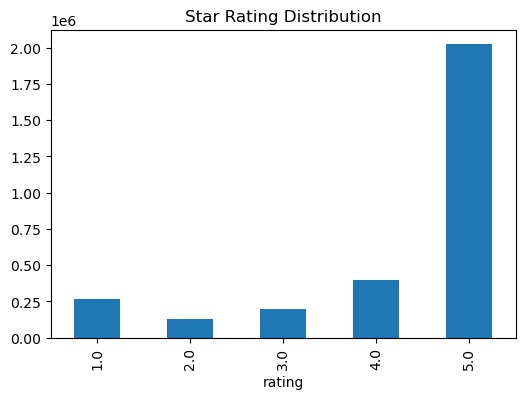


Distribution of new 'sentiment' column:
sentiment
1    2424515
0     592924
Name: count, dtype: int64

Shape of the final model DataFrame:
(3017439, 2)

First 5 rows of the final model DataFrame:
   sentiment                                   review_full_text
0          1  Five Stars. Great headphones, comfortable and ...
1          0  nice sound.  pedal failed after less than 1 ye...
2          1  okay. pretty good overall.  I like it.  the co...
3          0  Easy to return.. Too bad it didn't work. At le...
4          1  Good product despite tight bolt.. Good and stu...
finished


In [2]:
import matplotlib.pyplot as plt

# --- 1. Analyze star_rating distribution ---
print("Distribution of star ratings:")
print(df['rating'].value_counts())

# Optional: Create a bar plot to visualize the distribution
df['rating'].value_counts().sort_index().plot(kind='bar', 
                                                   title='Star Rating Distribution', 
                                                   figsize=(6, 4))
plt.show()


# --- 2. Create the binary 'sentiment' column ---
# We'll classify ratings of 1, 2, or 3 as negative (0) and 4 or 5 as positive (1).
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 3:
        return 0  # Negative
    else:
        return 1  # Positive

df['sentiment'] = df['rating'].apply(to_sentiment)
print("\nDistribution of new 'sentiment' column:")
print(df['sentiment'].value_counts())


# --- 3. Combine text fields ---
# First, fill any potential missing values (NaN) in text columns with empty strings

df['review_headline'] = df['title'].fillna('')
df['review_body'] = df['text'].fillna('')

# Create a new column by combining headline and body
df['review_full_text'] = df['title'] + '. ' + df['text']

# --- 4. Clean up the DataFrame ---
# Create a new DataFrame with only the columns we need for the model
df_model = df[['sentiment', 'review_full_text']].copy()
gc.collect()

print("\nShape of the final model DataFrame:")
print(df_model.shape)

print("\nFirst 5 rows of the final model DataFrame:")
print(df_model.head())
print("finished")

In [5]:
print()

In [4]:
# --- Save the final, ML-ready DataFrame to S3 ---

# Define the S3 path for our final training data
# We'll save it as a single Parquet file for simplicity.
train_data_path = f"s3://{bucket_name}/train-data/sentiment-train-data.parquet"

print(f"Saving final model data to: {train_data_path}")

# In the last cell, we created our final df and called it 'df'. Let's use it.
# If you called it df_model, please change 'df' to 'df_model' below.
df.to_parquet(train_data_path)

print("Successfully saved data to S3.")

Saving final model data to: s3://recproject-recdata/train-data/sentiment-train-data.parquet
Successfully saved data to S3.


In [ ]:
import sagemaker
from sagemaker.huggingface import HuggingFace

# --- 1. Define the S3 location of our training data ---
# This is the folder containing the 'sentiment-train-data.parquet' file.
train_data_s3_path = f"s3://{bucket_name}/train-data-sampled/"


# --- 2. Define Hyperparameters ---
# These will be passed as command-line arguments to our train.py script.
hyperparameters = {
    'epochs': 1,
    'train-batch-size': 32,
    'model-name': 'distilbert-base-uncased'
}


# --- 3. Configure the SageMaker Hugging Face Estimator ---
# The Estimator is the SageMaker SDK object that handles the training job.
huggingface_estimator = HuggingFace(
    entry_point='train.py',           # Our training script
    source_dir='./',                  # Directory where train.py is located
    instance_type='ml.g4dn.xlarge',   # A powerful GPU instance for training
    instance_count=1,
    role=sagemaker.get_execution_role(), # The IAM role we created for SageMaker
    transformers_version='4.28',      # Version of the Hugging Face library
    pytorch_version='2.0',            # Version of PyTorch
    py_version='py310',
    hyperparameters=hyperparameters
)


# --- 4. Launch the Training Job! ---
# The .fit() method starts the training job.
# We pass the S3 path of our data to the 'training' channel.
# This corresponds to the --training-dir argument in our train.py script.
print("Starting the SageMaker Training Job. This will take 20-30 minutes...")
huggingface_estimator.fit({'training': train_data_s3_path})

print("Training Job Complete.")

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Starting the SageMaker Training Job. This will take 20-30 minutes...


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: huggingface-pytorch-training-2025-06-17-03-00-08-848


2025-06-17 03:00:15 Starting - Starting the training job...
2025-06-17 03:00:30 Starting - Preparing the instances for training...
2025-06-17 03:00:57 Downloading - Downloading input data...
2025-06-17 03:01:22 Downloading - Downloading the training image..............................
2025-06-17 03:06:26 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-06-17 03:06:40,426 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-06-17 03:06:40,443 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-06-17 03:06:40,453 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-06-17 03:06:40,524 sagemaker_pytorch_container.training INFO     Invoking user training script.
2025-06-17 03:06:42,952 sagemaker-training-toolkit INFO     No Neurons de

In [8]:
print(f"Full dataset has {len(df)} reviews.")

# Create a random sample of 150,000 reviews
df_sample = df.sample(n=150000, random_state=42)
print(f"Sampled dataset has {len(df_sample)} reviews.")

# Define a new S3 path for our sampled data
sampled_train_data_path = f"s3://{bucket_name}/train-data-sampled/sentiment-train-data-sampled.parquet"

print(f"Saving sampled data to: {sampled_train_data_path}")

# Save the new sampled DataFrame to S3
df_sample.to_parquet(sampled_train_data_path)

print("Successfully saved sampled data to S3.")

Full dataset has 3017439 reviews.
Sampled dataset has 150000 reviews.
Saving sampled data to: s3://recproject-recdata/train-data-sampled/sentiment-train-data-sampled.parquet
Successfully saved sampled data to S3.


In [10]:
# --- Deploy the trained model to a SageMaker Real-Time Endpoint ---

# The .deploy() method creates a new endpoint and deploys our model to it.
# We are choosing a small, cost-effective instance type for this demo endpoint.
# The 'ml.t2.medium' instance is eligible for the AWS Free Tier.

print("Deploying model to a SageMaker Endpoint...")
print("This will take 5-10 minutes...")

predictor = huggingface_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium'
)

print("\nDeployment complete!")
print(f"Endpoint Name: {predictor.endpoint_name}")

INFO:sagemaker:Creating model with name: huggingface-pytorch-training-2025-06-17-04-48-36-362


Deploying model to a SageMaker Endpoint...
This will take 5-10 minutes...


INFO:sagemaker:Creating endpoint-config with name huggingface-pytorch-training-2025-06-17-04-48-36-362
INFO:sagemaker:Creating endpoint with name huggingface-pytorch-training-2025-06-17-04-48-36-362


-----------------------------------------!
Deployment complete!
Endpoint Name: huggingface-pytorch-training-2025-06-17-04-48-36-362


In [11]:
# --- Test the live endpoint with some sample reviews ---

test_reviews = [
    "This is the best musical instrument I have ever owned. The quality is outstanding and the sound is perfect.",
    "The guitar arrived with a huge crack in the body. It's unplayable and the support has been useless.",
    "It's okay for the price, but the tuning pegs feel a little cheap and it doesn't stay in tune very well.",
    "Wow, just wow! I am blown away by the rich tone of this piano."
]

print("--- Sending sample reviews to the endpoint for prediction ---\n")

for review in test_reviews:
    print(f"Review: \"{review}\"")
    
    # The .predict() method sends our data to the endpoint
    result = predictor.predict(data={"inputs": review})
    
    # The model returns a label ('LABEL_1' for positive, 'LABEL_0' for negative) and a confidence score
    predicted_label = result[0]['label']
    score = result[0]['score']
    
    # Let's make the output more user-friendly
    sentiment = "POSITIVE" if predicted_label == 'LABEL_1' else "NEGATIVE"
    
    print(f"--> Prediction: {sentiment} (Confidence: {score:.2%})\n")

--- Sending sample reviews to the endpoint for prediction ---

Review: "This is the best musical instrument I have ever owned. The quality is outstanding and the sound is perfect."


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:16                                                                                   │
│                                                                                                  │
│   13 │   print(f"Review: \"{review}\"")                                                          │
│   14 │                                                                                           │
│   15 │   # The .predict() method sends our data to the endpoint                                  │
│ ❱ 16 │   result = predictor.predict(data={"inputs": review})                                     │
│   17 │                                                                                           │
│   18 │   # The model returns a label ('LABEL_1' for positive, 'LABEL_0' for negative) and a c    │
│   19 │   predicted_label = result[0]['label']                                                    │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/base_predictor.py:212 in predict               │
│                                                                                                  │
│   209 │   │   if inference_component_name:                                                       │
│   210 │   │   │   request_args["InferenceComponentName"] = inference_component_name              │
│   211 │   │                                                                                      │
│ ❱ 212 │   │   response = self.sagemaker_session.sagemaker_runtime_client.invoke_endpoint(**req   │
│   213 │   │   return self._handle_response(response)                                             │
│   214 │                                                                                          │
│   215 │   def _handle_response(self, response):                                                  │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/botocore/client.py:569 in _api_call                      │
│                                                                                                  │
│    566 │   │   │   │   │   f"{py_operation_name}() only accepts keyword arguments."              │
│    567 │   │   │   │   )                                                                         │
│    568 │   │   │   # The "self" in this scope is referring to the BaseClient.                    │
│ ❱  569 │   │   │   return self._make_api_call(operation_name, kwargs)                            │
│    570 │   │                                                                                     │
│    571 │   │   _api_call.__name__ = str(py_operation_name)                                       │
│    572                                                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/botocore/client.py:1023 in _make_api_call                │
│                                                                                                  │
│   1020 │   │   │   │   "Code"                                                                    │
│   1021 │   │   │   )                                                                             │
│   1022 │   │   │   error_class = self.exceptions.from_code(error_code)                           │
│ ❱ 1023 │   │   │   raise error_class(parsed_response, operation_name)                            │
│   1024 │   │   else:                                                                             │
│   1025 │   │   │   return parsed_response                                                        │
│   1026                                                     

In [12]:
# --- Clean up and delete the endpoint to avoid ongoing costs ---
print("Deleting the SageMaker Endpoint...")
predictor.delete_endpoint()
print("Endpoint deleted.")

INFO:sagemaker:Deleting endpoint configuration with name: huggingface-pytorch-training-2025-06-17-04-48-36-362


Deleting the SageMaker Endpoint...


INFO:sagemaker:Deleting endpoint with name: huggingface-pytorch-training-2025-06-17-04-48-36-362


Endpoint deleted.


In [1]:
import sagemaker
import boto3
import pandas as pd

#
# THIS WAS CREATED TO RELOAD THE ENVIRONMENT AFTER SHUTTING DOWN FOR THE EVENING!!!
#

# --- IMPORTANT: REPLACE WITH YOUR BUCKET NAME ---
bucket_name = "recproject-recdata"
# ----------------------------------------------

# Get the SageMaker execution role
# This is the same role we've used throughout the project
role = sagemaker.get_execution_role()

print(f"Using bucket: {bucket_name}")
print(f"Using IAM role: {role}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Using bucket: recproject-recdata
Using IAM role: arn:aws:iam::468586614495:role/AWSSageMakerRole-SentimentProject


In [2]:
from sagemaker.huggingface import HuggingFace

# --- IMPORTANT: PASTE YOUR COMPLETED TRAINING JOB NAME HERE ---
training_job_name = "huggingface-pytorch-training-2025-06-17-03-00-08-848" # Replace with your job name
# -------------------------------------------------------------

# The .attach() method reconnects our code to the completed training job
huggingface_estimator = HuggingFace.attach(training_job_name=training_job_name)

print(f"Successfully re-attached to training job: {training_job_name}")


2025-06-17 04:44:45 Starting - Preparing the instances for training
2025-06-17 04:44:45 Downloading - Downloading the training image
2025-06-17 04:44:45 Training - Training image download completed. Training in progress.
2025-06-17 04:44:45 Uploading - Uploading generated training model
2025-06-17 04:44:45 Completed - Training job completed
Successfully re-attached to training job: huggingface-pytorch-training-2025-06-17-03-00-08-848


In [3]:
# --- Deploy the trained model to a SageMaker Real-Time Endpoint ---
print("Attempting to deploy model to a SageMaker Endpoint...")
print("This will take 5-10 minutes before it shows the error...")

try:
    predictor = huggingface_estimator.deploy(
        initial_instance_count=1,
        instance_type='ml.t2.medium' # Using the free-tier eligible instance
    )
    print("\nDeployment complete!")
    print(f"Endpoint Name: {predictor.endpoint_name}")

except Exception as e:
    # This will catch the error and print it clearly
    print("\n--- DEPLOYMENT FAILED ---")
    print(e)

Attempting to deploy model to a SageMaker Endpoint...
This will take 5-10 minutes before it shows the error...
---------------!
Deployment complete!
Endpoint Name: huggingface-pytorch-training-2025-06-17-15-01-22-237


In [4]:
# --- Test the live endpoint with some sample reviews ---

test_reviews = [
    "This is the best musical instrument I have ever owned. The quality is outstanding and the sound is perfect.",
    "The guitar arrived with a huge crack in the body. It's unplayable and the support has been useless.",
    "It's okay for the price, but the tuning pegs feel a little cheap and it doesn't stay in tune very well.",
    "Wow, just wow! I am blown away by the rich tone of this piano."
]

print("--- Sending sample reviews to the endpoint for prediction ---\n")

for review in test_reviews:
    print(f"Review: \"{review}\"")
    
    # The .predict() method sends our data to the endpoint
    result = predictor.predict(data={"inputs": review})
    
    # The model returns a label ('LABEL_1' for positive, 'LABEL_0' for negative) and a confidence score
    predicted_label = result[0]['label']
    score = result[0]['score']
    
    # Let's make the output more user-friendly
    sentiment = "POSITIVE" if predicted_label == 'LABEL_1' else "NEGATIVE"
    
    print(f"--> Prediction: {sentiment} (Confidence: {score:.2%})\n")

--- Sending sample reviews to the endpoint for prediction ---

Review: "This is the best musical instrument I have ever owned. The quality is outstanding and the sound is perfect."


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:16                                                                                   │
│                                                                                                  │
│   13 │   print(f"Review: \"{review}\"")                                                          │
│   14 │                                                                                           │
│   15 │   # The .predict() method sends our data to the endpoint                                  │
│ ❱ 16 │   result = predictor.predict(data={"inputs": review})                                     │
│   17 │                                                                                           │
│   18 │   # The model returns a label ('LABEL_1' for positive, 'LABEL_0' for negative) and a c    │
│   19 │   predicted_label = result[0]['label']                                                    │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/base_predictor.py:212 in predict               │
│                                                                                                  │
│   209 │   │   if inference_component_name:                                                       │
│   210 │   │   │   request_args["InferenceComponentName"] = inference_component_name              │
│   211 │   │                                                                                      │
│ ❱ 212 │   │   response = self.sagemaker_session.sagemaker_runtime_client.invoke_endpoint(**req   │
│   213 │   │   return self._handle_response(response)                                             │
│   214 │                                                                                          │
│   215 │   def _handle_response(self, response):                                                  │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/botocore/client.py:569 in _api_call                      │
│                                                                                                  │
│    566 │   │   │   │   │   f"{py_operation_name}() only accepts keyword arguments."              │
│    567 │   │   │   │   )                                                                         │
│    568 │   │   │   # The "self" in this scope is referring to the BaseClient.                    │
│ ❱  569 │   │   │   return self._make_api_call(operation_name, kwargs)                            │
│    570 │   │                                                                                     │
│    571 │   │   _api_call.__name__ = str(py_operation_name)                                       │
│    572                                                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/botocore/client.py:1023 in _make_api_call                │
│                                                                                                  │
│   1020 │   │   │   │   "Code"                                                                    │
│   1021 │   │   │   )                                                                             │
│   1022 │   │   │   error_class = self.exceptions.from_code(error_code)                           │
│ ❱ 1023 │   │   │   raise error_class(parsed_response, operation_name)                            │
│   1024 │   │   else:                                                                             │
│   1025 │   │   │   return parsed_response                                                        │
│   1026                                                     

In [5]:
print("Deleting the old, non-working endpoint...")
predictor.delete_endpoint()
print("Endpoint deleted.")

Deleting the old, non-working endpoint...
Endpoint deleted.


In [ ]:
# This is the cell from before that you need to run again
huggingface_estimator.fit({'training': 's3://' + bucket_name + '/train-data-sampled/'})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: huggingface-pytorch-training-2025-06-17-15-21-56-149


2025-06-17 15:21:57 Starting - Starting the training job...
2025-06-17 15:22:12 Starting - Preparing the instances for training...
2025-06-17 15:22:45 Downloading - Downloading input data...
2025-06-17 15:23:05 Downloading - Downloading the training image..............................
2025-06-17 15:28:19 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-06-17 15:28:30,512 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-06-17 15:28:30,530 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2025-06-17 15:28:30,540 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-06-17 15:28:30,546 sagemaker_pytorch_container.training INFO     Invoking user training script.
2025-06-17 15:28:32,998 sagemaker-training-toolkit INFO     No Neurons d

In [8]:
print("foobar")

foobar


In [9]:
from sagemaker.huggingface import HuggingFace

# PASTE THE JOB NAME THAT SHOWS as 'Completed' IN THE CONSOLE
completed_job_name = "huggingface-pytorch-training-2025-06-17-15-21-56-149" 

print(f"Attaching to completed job: {completed_job_name}")
huggingface_estimator = HuggingFace.attach(training_job_name=completed_job_name)

print("Successfully attached. Ready to deploy.")

Attaching to completed job: huggingface-pytorch-training-2025-06-17-15-21-56-149

2025-06-17 17:06:52 Starting - Preparing the instances for training
2025-06-17 17:06:52 Downloading - Downloading the training image
2025-06-17 17:06:52 Training - Training image download completed. Training in progress.
2025-06-17 17:06:52 Uploading - Uploading generated training model
2025-06-17 17:06:52 Completed - Training job completed
Successfully attached. Ready to deploy.


In [10]:
# --- Deploy the successfully trained model to a SageMaker Real-Time Endpoint ---

print("Deploying the new, correct model to a SageMaker Endpoint...")
print("This will take 5-10 minutes...")

try:
    # The .deploy() method creates the endpoint using the model from our attached training job
    predictor = huggingface_estimator.deploy(
        initial_instance_count=1,
        instance_type='ml.t2.medium' # Using the free-tier eligible instance
    )

    print("\n✅ Deployment complete!")
    print(f"Endpoint Name: {predictor.endpoint_name}")

except Exception as e:
    print("\n❌ DEPLOYMENT FAILED")
    print("Even with the completed job, deployment failed. This can sometimes happen due to transient AWS issues.")
    print(f"Error details: {e}")

Deploying the new, correct model to a SageMaker Endpoint...
This will take 5-10 minutes...


INFO:sagemaker:Creating model with name: huggingface-pytorch-training-2025-06-17-18-11-34-598
INFO:sagemaker:Creating endpoint-config with name huggingface-pytorch-training-2025-06-17-18-11-34-598
INFO:sagemaker:Creating endpoint with name huggingface-pytorch-training-2025-06-17-18-11-34-598


--------------!
✅ Deployment complete!
Endpoint Name: huggingface-pytorch-training-2025-06-17-18-11-34-598


In [11]:
# --- Test the live endpoint with some sample reviews ---

test_reviews = [
    "This is the best musical instrument I have ever owned. The quality is outstanding and the sound is perfect.",
    "The guitar arrived with a huge crack in the body. It's unplayable and the support has been useless.",
    "It's okay for the price, but the tuning pegs feel a little cheap and it doesn't stay in tune very well.",
    "Wow, just wow! I am blown away by the rich tone of this piano."
]

print("--- Sending sample reviews to the endpoint for prediction ---\n")

for review in test_reviews:
    print(f"Review: \"{review}\"")
    
    # The .predict() method sends our data to the endpoint
    result = predictor.predict(data={"inputs": review})
    
    # The model returns a label ('LABEL_1' for positive, 'LABEL_0' for negative) and a confidence score
    predicted_label = result[0]['label']
    score = result[0]['score']
    
    # Let's make the output more user-friendly
    sentiment = "POSITIVE" if predicted_label == 'LABEL_1' else "NEGATIVE"
    
    print(f"--> Prediction: {sentiment} (Confidence: {score:.2%})\n")

--- Sending sample reviews to the endpoint for prediction ---

Review: "This is the best musical instrument I have ever owned. The quality is outstanding and the sound is perfect."


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:16                                                                                   │
│                                                                                                  │
│   13 │   print(f"Review: \"{review}\"")                                                          │
│   14 │                                                                                           │
│   15 │   # The .predict() method sends our data to the endpoint                                  │
│ ❱ 16 │   result = predictor.predict(data={"inputs": review})                                     │
│   17 │                                                                                           │
│   18 │   # The model returns a label ('LABEL_1' for positive, 'LABEL_0' for negative) and a c    │
│   19 │   predicted_label = result[0]['label']                                                    │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/sagemaker/base_predictor.py:212 in predict               │
│                                                                                                  │
│   209 │   │   if inference_component_name:                                                       │
│   210 │   │   │   request_args["InferenceComponentName"] = inference_component_name              │
│   211 │   │                                                                                      │
│ ❱ 212 │   │   response = self.sagemaker_session.sagemaker_runtime_client.invoke_endpoint(**req   │
│   213 │   │   return self._handle_response(response)                                             │
│   214 │                                                                                          │
│   215 │   def _handle_response(self, response):                                                  │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/botocore/client.py:569 in _api_call                      │
│                                                                                                  │
│    566 │   │   │   │   │   f"{py_operation_name}() only accepts keyword arguments."              │
│    567 │   │   │   │   )                                                                         │
│    568 │   │   │   # The "self" in this scope is referring to the BaseClient.                    │
│ ❱  569 │   │   │   return self._make_api_call(operation_name, kwargs)                            │
│    570 │   │                                                                                     │
│    571 │   │   _api_call.__name__ = str(py_operation_name)                                       │
│    572                                                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.12/site-packages/botocore/client.py:1023 in _make_api_call                │
│                                                                                                  │
│   1020 │   │   │   │   "Code"                                                                    │
│   1021 │   │   │   )                                                                             │
│   1022 │   │   │   error_class = self.exceptions.from_code(error_code)                           │
│ ❱ 1023 │   │   │   raise error_class(parsed_response, operation_name)                            │
│   1024 │   │   else:                                                                             │
│   1025 │   │   │   return parsed_response                                                        │
│   1026                                                     

In [12]:
# --- Test the live endpoint with some sample reviews ---

test_reviews = [
    "This is the best musical instrument I have ever owned. The quality is outstanding and the sound is perfect.",
    "The guitar arrived with a huge crack in the body. It's unplayable and the support has been useless.",
    "It's okay for the price, but the tuning pegs feel a little cheap and it doesn't stay in tune very well.",
    "Wow, just wow! I am blown away by the rich tone of this piano."
]

print("--- Sending sample reviews to the live endpoint for prediction ---\n")

try:
    for review in test_reviews:
        print(f"Review: \"{review}\"")
        
        # The .predict() method sends our data to the endpoint
        result = predictor.predict(data={"inputs": review})
        
        # The model returns a label ('LABEL_1' for positive, 'LABEL_0' for negative) and a confidence score
        predicted_label = result[0]['label']
        score = result[0]['score']
        
        # Let's make the output more user-friendly
        sentiment = "POSITIVE" if predicted_label == 'LABEL_1' else "NEGATIVE"
        
        print(f"--> Prediction: {sentiment} (Confidence: {score:.2%})\n")

    print("✅ All predictions were successful!")

except Exception as e:
    print(f"\n❌ An error occurred during prediction: {e}")

--- Sending sample reviews to the live endpoint for prediction ---

Review: "This is the best musical instrument I have ever owned. The quality is outstanding and the sound is perfect."

❌ An error occurred during prediction: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (400) from primary with message "{
  "code": 400,
  "type": "InternalServerException",
  "message": "Can\u0027t load tokenizer for \u0027/opt/ml/model\u0027. If you were trying to load it from \u0027https://huggingface.co/models\u0027, make sure you don\u0027t have a local directory with the same name. Otherwise, make sure \u0027/opt/ml/model\u0027 is the correct path to a directory containing all relevant files for a DistilBertTokenizerFast tokenizer."
}
". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/huggingface-pytorch-training-2025-06-17-18-11-34-598 in account 468586614495 for more infor

In [13]:
print("Deleting the old, non-working endpoint...")
predictor.delete_endpoint()
print("Endpoint deleted.")

INFO:sagemaker:Deleting endpoint configuration with name: huggingface-pytorch-training-2025-06-17-18-11-34-598


Deleting the old, non-working endpoint...


INFO:sagemaker:Deleting endpoint with name: huggingface-pytorch-training-2025-06-17-18-11-34-598


Endpoint deleted.
